# Meridional heat transport for MPAS-Ocean CORE II runs

This notebook details a Python-based method for calculating meridional heat transport in the MPAS-Ocean LR and HR Core II simulations.

#### Optimized edge interpolation

The method used in this notebook optimizes the interpolation of cell variables to edges by defining a `subdomainEdge` nested inside a `subdomainCell`. The interpolation-to-edge step requires that a new `cellsOnEdge` array be retrieved that specifically references cells on `subdomainCell`. The function `get_cellsOnEdge_subdomain` performs this task once and then saves the array to netCDF. This process takes about 15-20 min for the HR mesh, but the cost savings for processing the HR results are significant. Using an Atlantic Basin subdomain, this method can calculate one year of MHT at HR in about 10 minutes using about 25G memory on a perlmutter login node.

**Important Note:** The HR meshfiles in `/global/cfs/cdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/` have nonsense edge IDs in the fill value places in the `edgesOnCell` variable, which should be zero but are not. This notebook identifies these values by comparing `nCells` to `cellsOnEdge` at these edge IDs.

***

In [1]:
import numpy as np
import xarray as xr
import yaml
import sys
import os
from matplotlib import pyplot as plt, patches
from tqdm import tqdm

# Import modules from path
sys.path.append('../modules/')
import calc_transformation_budget as trtools

plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

### Definitions

Heat transport decomposition

$$\overline{vT} = \overline{v}\overline{T} + \overline{v'T'}$$

**In the HR**

$$v = v_{model}$$

$$\overline{v_{model}T} = \overline{v_{model}}\overline{T} + \overline{v_{model}'T'}$$

**In the LR**

$$v = v_{model} + v_{GM}$$

$$\overline{v_{model}T} + \overline{v_{GM}T} = \overline{v_{model}}\overline{T} + \overline{(v_{model} + v_{GM})'T'}$$

In the results files we have

| <div style="width:130px">Term</div> | Description | MPAS Definition |
| - | - | - |
| $\overline{v_{model}T}$ | Resolved heat transport | `normalVelocityTimesTemperature` |
| $\overline{v_{GM}T}$ | GM heat transport | `normalGMBolusVelocityTimesTemperature` |
| $\overline{v_{model}}\overline{T}$ | Heat transport by the mean velocity | `normalVelocity` $\times$ `activeTracers_temperature` |
| $\overline{(v_{model} + v_{GM})'T'}$ | Time-varying + GM heat transport | $\overline{v_{model}T} + \overline{v_{GM}T} - \overline{v_{model}}\overline{T}$ |

***

### Functions

In [10]:
def build_bottom_mask():
    """Bottom mask code, currently unused
    """
    
    # Bottom mask
    edgelevel = np.broadcast_to(maxLevelCell[cells].values[:, None], (len(cells), 7)).ravel()
    shape = (len(edges), len(nVertLevels))
    index2D = np.broadcast_to(nVertLevels[None, :], shape) < edgelevel[:, None]


def remap2edge(variable, cellsOnEdge):
    """Remap variable to edge by averaging cells on either side
    """
    
    # Remap to edge by averaging cells on either side
    neighbors = [variable[col, :] for col in cellsOnEdge.T]
    variable_remapped = (neighbors[0] + neighbors[1]) / 2
    
    return variable_remapped


def build_subdomain(lons, lats, bbox, buf=0):
    """
    """
    
    # Build subdomain
    subdomain, = np.where((lons>bbox[0]-buf) & (lons<bbox[1]+buf) & (lats>bbox[2]-buf) & (lats<bbox[3]+buf))
    
    return subdomain


def get_cellsOnEdge_subdomain(
    coords, savepath,
    history_url='https://github.com/MPAS-Dev/MPAS-QuickViz/blob/master/ocean/AMOC/watermassanalysis/notebooks/MHT.ipynb',
):
    """Find cellsOnEdge on subdomain
    """
    
    # Find cellsOnEdge on subdomain
    cells, subdomain = [coords[name] for name in ('cellsOnEdge', 'subdomainCell')]
    subdomain_cellsOnEdge = np.array([np.where(np.isin(subdomain, pair, kind='sort'))[0] for pair in tqdm(cells)])

    # Save to netCDF out
    ds_attrs = {'history': history_url}
    var_attrs = {'long_name': 'List of cells in subdomainCell that border each edge in subdomainEdge'}
    ds = xr.Dataset({'subdomain_cellsOnEdge': (['nEdges', 'TWO'], subdomain_cellsOnEdge, var_attrs)}, attrs=ds_attrs)
    ds.to_netcdf(savepath)


def get_edge_signs(nCells, cellsOnEdge, edgesOnCell):
    """
    """
    
    # Build edge signs
    isNegative = cellsOnEdge[edgesOnCell, 0] == nCells
    edgeSignOnCell = np.where(isNegative, -1, 1)
    
    return edgeSignOnCell


def load_mesh_variables(paths):
    """Load mesh variables
    """
    
    # Get region mask
    with xr.open_dataset(paths['maskfile_AO']) as ds:
        regionMask = ds.regionCellMasks[:, 0].values.astype(bool)
        
    # Get mesk variables
    with xr.open_dataset(paths['meshfile']) as ds:

        # Get coordinate variables
        names = ['lonCell', 'latCell', 'lonEdge', 'latEdge']
        lonCell, latCell, lonEdge, latEdge = [np.rad2deg(ds[name].values) for name in names]
        lonCell, lonEdge = [np.where(var > 180, var - 360, var) for var in (lonCell, lonEdge)]

        # Get dimension and index variables
        nCells = ds.nCells.values[:, None]
        shapeEdge = [ds.dims[dim] for dim in ('nEdges', 'nVertLevels')]
        cellsOnEdge, edgesOnCell = [ds[name].values - 1 for name in ('cellsOnEdge', 'edgesOnCell')]
        
        # Get dvEdge
        dvEdge = ds.dvEdge.values

    # Get edge signs on cell and build southern transect mask
    edgeSignOnCell = get_edge_signs(nCells, cellsOnEdge, edgesOnCell)
    edges, signs, ipoleward = trtools.get_region_edges('Atlantic Basin', regionMask, cellsOnEdge, lonEdge, latEdge)

    # Build subdomains
    bbox = [-99, 26, -36, 84]
    subdomainCell = build_subdomain(lonCell, latCell, bbox, buf=1)
    subdomainEdge = build_subdomain(lonEdge, latEdge, bbox, buf=0)
    subdomainEdge = subdomainEdge[np.all(cellsOnEdge[subdomainEdge, :] > 0, axis=1)]
    
    # Replace nonsense edge IDs with -1 in `edgesOnCell` (problem for HR meshfile)
    nCells, edgesOnCell = nCells[subdomainCell, :, None], edgesOnCell[subdomainCell, :]
    badEdges = np.all(cellsOnEdge[edgesOnCell, :] != nCells, axis=2)
    edgesOnCell[badEdges] = -1

    # Build output dict
    coords = {
        'zerosEdge': np.zeros(shapeEdge),
        'subdomainCell': subdomainCell,
        'subdomainEdge': subdomainEdge,
        'latCell': latCell[subdomainCell],
        'dvEdge': dvEdge[subdomainEdge, None],
        'cellsOnEdge': cellsOnEdge[subdomainEdge, :],
        'edgesOnCell': edgesOnCell,
        'edgeSignOnCell': edgeSignOnCell[subdomainCell, :],
        'regionMask': regionMask[subdomainCell],
        'transectMask': edges[~ipoleward],
        'transectSigns': signs[~ipoleward, None],
    }
    
    return coords

***

### Run the code

Get coordinates and subdomains

In [11]:
meshName = 'HR'

# Constants
rho0 = 1026.0     # Seawater density constant [kg m-3]
cpsw = 3.996e3    # Heat capacity of seawater [J kg-1 K-1]

# Latitude bins
binsize = 1
latbins = np.arange(-35, 81, binsize)

# Variable names
components = ['total', 'mean', 'vary']
prefix = 'timeMonthly_avg_'
namesCell = ['layerThickness', 'activeTracers_temperature']
namesEdge = ['normalVelocity', 'normalVelocityTimesTemperature']
if meshName == 'LR':
    namesEdge.extend(['normalGMBolusVelocity', 'normalGMBolusVelocityTimesTemperature'])

# Get paths
with open(f'../yaml/paths_{meshName}.yaml', 'r') as f:
    paths = yaml.safe_load(f)

# Build results prefix
resultsprefix = paths['results']['1997-2007'] + '/' + paths['prefix']

# Get coords
coords = load_mesh_variables(paths)

# Load subdomain_cellsOnEdge, or build the file if non-existent
filename = f'/pscratch/sd/b/bmoorema/maskfiles/MHT_{meshName}_subdomain_cellsOnEdge.nc'
if not os.path.isfile(filename):
    get_cellsOnEdge_subdomain(coords, filename)
with xr.open_dataset(filename) as ds:
    subdomain_cellsOnEdge = ds.subdomain_cellsOnEdge.values

Loop through monthly files and calculate MHT

In [12]:
# Initialize storage lists
MHT = {component + 'MHT': [] for component in components}

# Loop through years and months
for year in range(51, 61):
    for month in tqdm(range(1, 13), desc=f'Loading year {year}'):

        # Open results file
        with xr.open_dataset(resultsprefix + f'.{year:04d}-{month:02d}-01.nc') as ds:

            # Load edge variables
            variables = {name: ds[prefix + name][0, ...].values[coords['subdomainEdge'], :] for name in namesEdge}

            # Load cell variables and interpolate to cell edges
            for name in namesCell:
                variable = ds[prefix + name][0, ...].values[coords['subdomainCell'], :]
                variables[name] = remap2edge(variable, subdomain_cellsOnEdge)

        # Cell edge area
        areaEdge = variables['layerThickness'] * coords['dvEdge']

        # v x T
        variables['vT_mean' ] = variables['normalVelocity']
        variables['vT_total'] = variables['normalVelocityTimesTemperature']
        if meshName == 'LR':
            variables['vT_mean' ] = variables['vT_mean' ] + variables['normalGMBolusVelocity']
            variables['vT_total'] = variables['vT_total'] + variables['normalGMBolusVelocityTimesTemperature']
        variables['vT_mean'] = variables['vT_mean' ] * variables['activeTracers_temperature']
        variables['vT_vary'] = variables['vT_total'] - variables['vT_mean']

        # Calculate heat transport rate [PW] and initialize MHT with southern transect
        mht = {}
        for component in components:    
            transport = 1e-15 * rho0 * cpsw * variables['vT_' + component] * areaEdge
            variables['vT_' + component] = np.copy(coords['zerosEdge'])
            variables['vT_' + component][coords['subdomainEdge'], :] = transport
            mht_bin = np.sum(variables['vT_' + component][coords['transectMask'], :] * coords['transectSigns'], axis=(0, 1))
            mht[component] = [mht_bin]

        # Loop through latitude bins
        for latbin in latbins:

            # Get edge indices
            cells = (coords['latCell'] > latbin) & (coords['latCell'] < latbin + binsize) & coords['regionMask']
            edges, signs = [coords[name][cells, :].ravel() for name in ('edgesOnCell', 'edgeSignOnCell')]
            index = edges >= 0
            edges, signs = edges[index], signs[index, None]

            # Loop through heat transport components and sum
            for component in components:
                mht_bin = -np.sum(variables['vT_' + component][edges, :] * signs, axis=(0, 1))
                mht[component].append(mht_bin)

        # Append to storage lists
        for component in components:
            MHT[component + 'MHT'].append(mht[component])

# Save netCDF output
for component in components:
    MHT[component + 'MHT'] = (['months', 'latbins'], np.cumsum(np.array(MHT[component + 'MHT']), axis=1)[:, 1:])
ds = xr.Dataset(MHT, {'latbins': latbins})
ds.to_netcdf(f'/pscratch/sd/b/bmoorema/results/aggregated/mht/MHT_{meshName}_19972007.nc')

Loading year 60: 100%|██████████| 12/12 [08:49<00:00, 44.09s/it]


***

### Visualization

Load Trenberth et al. 2019 ensemble mean Atlantic MHT

In [63]:
# Load observations
filename = '/pscratch/sd/b/bmoorema/data/Fig_12a_2000_2016_monthly_ZonalSum_AtlanticArctic_0-2000m_ensemble_mean.txt'
years, latbins_obs = np.arange(2000, 2016), np.arange(-33.5, 64.51, 1)
mht_obs = []
with open(filename) as f:
    for k in range(2):
        _ = f.readline()
    for year in range(2000, 2016):
        line = f.readline()
        values = [[float(val) for val in f.readline().split(None)] for lat in latbins]
        mht_obs.append(values)

mht_obs = np.array(mht_obs)
mht_obs_mean = mht_obs.mean(axis=(0, 2))
mht_obs_iqr = [np.percentile(mht_obs, p, axis=(0, 2)) for p in (25, 75)]

Load and plot LR and HR MHT from netCDF

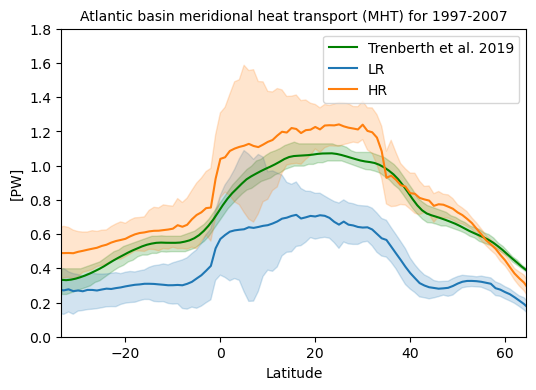

In [76]:
# Plot MHT
palette = plt.get_cmap('tab10').colors
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Atlantic basin meridional heat transport (MHT) for 1997-2007')

# Plot observations
ax.plot(latbins_obs, mht_obs_mean, color='g', label='Trenberth et al. 2019')
ax.fill_between(latbins_obs, *mht_obs_iqr, fc='g', ec='g', alpha=0.2)

for meshName, color in zip(['LR', 'HR'], palette):
    ds = xr.open_dataset(f'/pscratch/sd/b/bmoorema/results/aggregated/mht/MHT_{meshName}_19972007.nc')
    
    mht = ds.meanMHT.values
    mht_mean = mht.mean(axis=0)
    mht_iqr = [np.percentile(mht, p, axis=0) for p in (25, 75)]

    # Plot my data
    ax.plot(ds.latbins, mht_mean, color=color, label=meshName)
    ax.fill_between(ds.latbins, *mht_iqr, fc=color, ec=color, alpha=0.2)

ax.set_xlim(-33.5, 64.5)
ax.set_ylim(0, 1.8)
ax.set_xlabel('Latitude')
ax.set_ylabel('[PW]')
ax.legend(loc=1)
fig.savefig('/pscratch/sd/b/bmoorema/posterfigs/MHT.pdf', bbox_inches='tight')